# Setup

In [ ]:
import numpy as np
import pandas as pd
import csv
import os
import glob
from PIL import Image, ImageOps

import time
import copy
import h5py
import scipy
import random
import itertools
import matplotlib.pyplot as plt
from scipy import ndimage
import torch
from torch import nn
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [6]:
CSV_FILE_NAME = './data/my_file.csv'
arr = pd.read_csv(CSV_FILE_NAME, header=None)
# print(arr)
arr = shuffle(arr)
arr.reset_index(drop=True)
img_size = len(arr.columns) -5
print(img_size)
data, labels = arr.iloc[:, :img_size], arr.iloc[:, img_size:img_size+1]
print(data.shape)
print(labels.shape)
data = data.to_numpy()
labels = labels.to_numpy()


ohe = OneHotEncoder(sparse_output=False).fit(labels)
print(ohe.categories_)
y = ohe.transform(labels)
# print(y)
# print(labels)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

10000
(649, 10000)
(649, 1)
[array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15.])]
(519, 10000)
(519, 17)


# EZ

In [7]:
device = "cpu"
class ClassNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(img_size, 5000),
            nn.ReLU(),
            nn.Linear(5000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, 17),
            # nn.LogSoftmax(1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def isRight(pred, y_arr):
    ctr = 0
    # print(pred.shape)
    # print(y_arr.shape)
    for i in range(len(pred)):
        # print(i)
        p = max(pred[i]).item()
        if (pred[i] == p).nonzero(as_tuple=True)[0] == (y_arr[i] == 1).nonzero(as_tuple=True)[0]:
            ctr = ctr+1
    # print(ctr)
    return ctr

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    tot_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        tot_loss += loss.item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    tot_loss/=len(dataloader)
    return tot_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += isRight(pred, y)
    test_loss /= num_batches
    #Scorrect /=size
    return test_loss, correct

def cross_entropy_one_hot(input, target):
    _, labels = target.max(dim=0)
    return nn.CrossEntropyLoss()(input, labels)

net = ClassNet().to(device)
print(net)

ClassNet(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10000, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=25, bias=True)
    (7): ReLU()
    (8): Linear(in_features=25, out_features=17, bias=True)
  )
)


In [11]:
# X_train, X_test, y_train, y_test
tens_train_x = torch.Tensor(X_train)
tens_train_y = torch.Tensor(y_train)
tens_val_x = torch.Tensor(X_test)
tens_val_y = torch.Tensor(y_test)

train_set = torch.utils.data.TensorDataset(tens_train_x, tens_train_y)
train_load = torch.utils.data.DataLoader(train_set, batch_size = len(X_train[0]))
val_set = torch.utils.data.TensorDataset(tens_val_x, tens_val_y)
val_load = torch.utils.data.DataLoader(val_set, batch_size = len(X_test[0]))

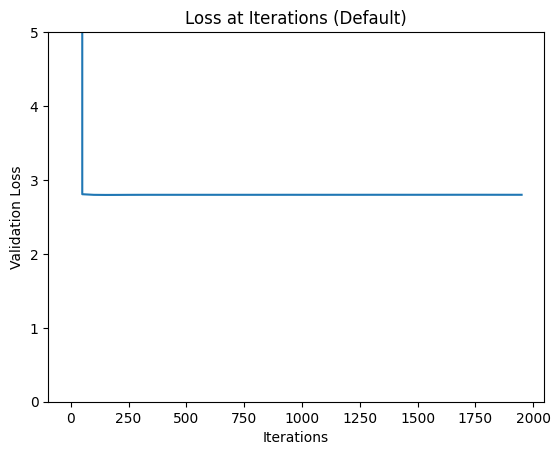

[22117038.0, 2.8072144985198975, 2.7988204956054688, 2.7974166870117188, 2.7978720664978027, 2.798598527908325, 2.7990541458129883, 2.799220323562622, 2.7992472648620605, 2.7992427349090576, 2.79923939704895, 2.79923939704895, 2.79923939704895, 2.799239158630371, 2.799239158630371, 2.79923939704895, 2.79923939704895, 2.799267292022705, 2.799290180206299, 2.799456834793091, 2.799243927001953, 2.799400806427002, 2.7992255687713623, 2.799433469772339, 2.799298048019409, 2.7993967533111572, 2.799546957015991, 2.7995834350585938, 2.7995240688323975, 2.7995176315307617, 2.7995452880859375, 2.799595832824707, 2.7996790409088135, 2.7997920513153076, 2.799882173538208, 2.799863815307617, 2.799752712249756, 2.799636125564575, 2.7995619773864746, 2.7995293140411377]
[14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


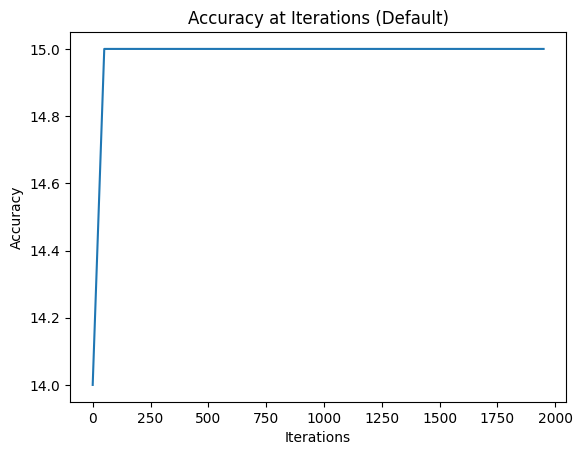

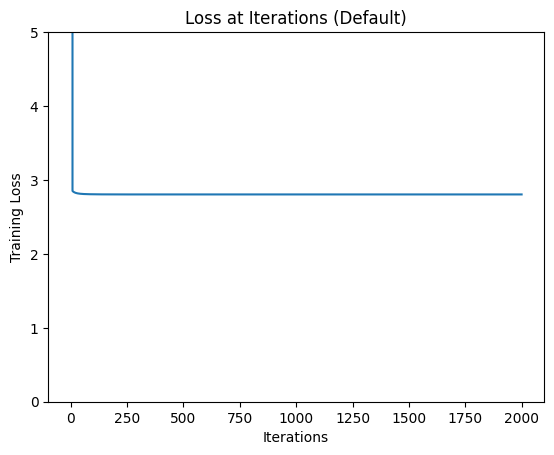

In [15]:
epochs = 2000
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(net.parameters())
train_loss = []
losses = []
accs = []


net.apply(init_weights)

for t in range(epochs):
    train_loss.append(train(train_load, net, loss_fn, optimizer))
    if(t%50 ==0):
        # print(f"Epoch {t+1}\n-------------------------------")
        a, b = test(val_load, net, loss_fn)
        losses.append(a)
        accs.append(b)
        
plt.plot(list(range(0, epochs, 50)), losses)
plt.ylim(0, 5)
plt.ylabel('Validation Loss')
plt.xlabel('Iterations')
plt.title('Loss at Iterations (Default)')
plt.show()
print(losses)
print(accs)

plt.plot(list(range(0, epochs, 50)), accs)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('Accuracy at Iterations (Default)')
plt.show()

plt.plot(list(range(0, epochs)), train_loss)
plt.ylim(0, 5)
plt.ylabel('Training Loss')
plt.xlabel('Iterations')
plt.title('Loss at Iterations (Default)')
plt.show()